In [2]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import igraph
from collections import Counter
import networkx as nx

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics
import seaborn as sns
from helpers.networks import *
import helpers.linkage as lkg
import helpers.style as style

style.load_style()

cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = dataloader.load(cf,agg_level='speech',model_type='lda',num_topics=250)
dists = data['dists']
labels = data['labels']
data = data['data']

In [21]:
# Filter 1945 + 1967, years with hardly any data
dists = dists[(dists.index.year > 1945) & (dists.index.year < 1967)]

In [9]:
# Create a dictionary of date (year):theta pairs
dict_date_theta = {d:_.to_numpy() for d,_ in dists.groupby(dists.index.to_period('Y'))}
stats, mi_arrays = diachronic_linkage(dict_date_theta)
stats = get_network_statistics(dict_date_theta=mi_arrays,thr=0)

100%|██████████| 21/21 [00:02<00:00,  7.78it/s]


# Plot Basic Network Metrics Over Time

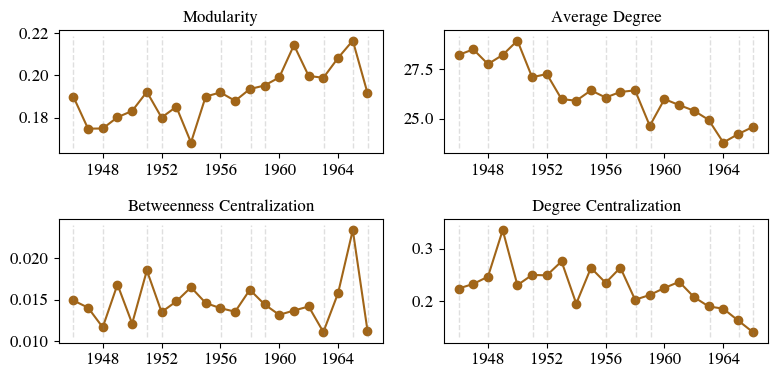

In [11]:
fig = plt.figure(figsize=(8,4))

for n,metric in enumerate(list(stats.columns)[1:]):
    ax = plt.subplot(2, 2, n + 1)
    ax.plot(stats.date.dt.to_timestamp(),stats[metric],marker='o')
    title = metric.split('_')
    title = ' '.join([w.capitalize() for w in title])
    ax.set_title(title)
    add_cabinet_periods(ax,text=False,alpha=.25,color='grey',max_time=1966)
plt.subplots_adjust(hspace=.5)
fig.tight_layout()
plt.savefig('figs/networks-statistics-year-weight-threshold-0.pdf',dpi=250)
plt.show()

# Plot Betweenness & Degree as Scatter Plots per (Merged) Cabinet Periods

Some cabinets served mainly as transitory ones, preparing the next election. They are merged with the preceding cabinet, since usually the same policy and government members were sustained.

/tmp/ipykernel_1938/2199552543.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)


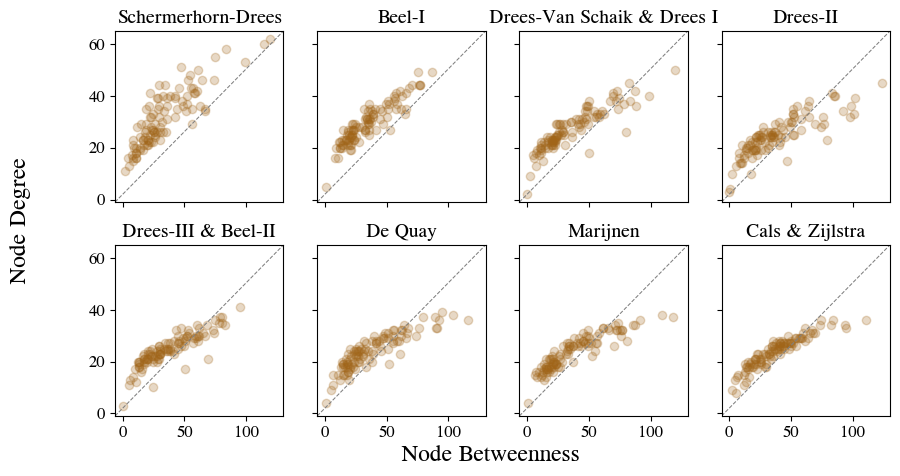

In [18]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

fig,axs = plt.subplots(2,4,figsize=(10,5),sharey=True,sharex=True)
axs = axs.flatten()
for c,(i,r) in enumerate(cab_.iterrows()):
    mask = (dists.index > r['startdate']) & (dists.index <= r['enddate'])
    theta = dists.loc[mask].to_numpy()
    theta,_,__ = mutual_information(theta)

    g,cmty,fmx = get_network_from_mi_theta(theta,thr=0)
    btw_vals = np.array(g.betweenness())
    deg_vals = np.array(g.degree())

    xmin,xmax = axs[c].get_xlim()
    ymin,ymax = axs[c].get_ylim()

    axs[c].scatter(btw_vals,deg_vals,alpha=.25)

    axs[c].set_title(r['cabinet'],fontsize=14)
    # axs[c].set_ylabel('Degree')
    # axs[c].set_xlabel('Betweenness')

    line = mlines.Line2D([0, 1], [0, 1], color='grey',linewidth=.75,linestyle='--')
    transform = axs[c].transAxes
    line.set_transform(transform)
    axs[c].add_line(line)   

fig.supylabel('Node Degree')
fig.supxlabel('Node Betweenness')
plt.subplots_adjust(hspace=.25)
plt.savefig('figs/networks-cabinets-betweenness-degree.pdf',dpi=250)
plt.show()